In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

import time

In [2]:
df_digest_protein = pd.read_csv('data/uniprot/df_digest_protein.csv')

In [3]:
print(df_digest_protein.shape)
df_digest_protein.head(1)

(5853, 5)


,PROTEIN,SEQUENCE,PROTEIN_FULL,SPECTRAL_CNT,SPECTRAL_CNT_MISS
0,sp|Q9NP61|ARFG3_HUMAN,MGDPSKQDILTIFKRLRSVPTNKVCFDCGAKNPSWASITYGVFLCI...,>sp|Q9NP61|ARFG3_HUMAN ADP-ribosylation factor...,M_2;G_206;D_0;P_5;S_0;K_0;Q_7;D_3;I_3;L_3;T_3;...,M_2;G_208;D_208;P_213;S_213;K_213;Q_217;D_217;...


# Digestibility Modeling
  - labelling followed AP3 paper

In [4]:
def labelling_ap3(prot2cnt, prot2cnt_miss, THRESHOLD = 4):  # prot2cnt, prot2cnt_miss must be list split by ;

    ts2label = dict()
    # protein loop
    for idx in range(len(prot2cnt)):
        # amino acid loop in one protein
        for amino_idx in range(len(prot2cnt[idx])):
            # tryptic site : K, R
            if prot2cnt[idx][amino_idx][:1] in 'KR':
                
                # *******TRYPTIC SITE EXTRACTING FROM PROTEIN*******
                # tryptic site in protein N-terminal
                if amino_idx <= THRESHOLD - 1:
                    tryptic_site = 'Z'*(THRESHOLD-amino_idx) + ''.join([a[0] for a in prot2cnt[idx][: amino_idx+THRESHOLD + 1]])  # added Z
                # tryptic site in protein C-terminal
                elif amino_idx >= len(prot2cnt[idx]) - THRESHOLD:
                    tryptic_site = ''.join([a[0] for a in prot2cnt[idx][amino_idx-THRESHOLD: amino_idx+THRESHOLD + 1]]) + 'Z'*(THRESHOLD-(len(prot2cnt[idx])-1)+amino_idx)  # added Z
                else:
                    tryptic_site = ''.join([a[0] for a in prot2cnt[idx][amino_idx-THRESHOLD: amino_idx+THRESHOLD + 1]])

                    
                # *******TRYPTIC SITE LABELLING (WHEN POSITIVE)*******
                # N-terminal of tryptic site condition
                N_condition = int(prot2cnt[idx][amino_idx][2:])
                # C-terminal of tryptic site condition
                if amino_idx == len(prot2cnt[idx]) - 1:  # tryptic site in last position of protein
                    C_condition = 0
                else:
                    C_condition = int(prot2cnt[idx][amino_idx + 1][2:])
                # miss cleavage of tryptic site contidion
                miss_condition = int(prot2cnt_miss[idx][amino_idx][2:])
                
                if (miss_condition + max(N_condition, C_condition))==0:
                    continue  # skip this tryptic site, because this site not yet detected.
                else:
                    condition = max(N_condition, C_condition) / (miss_condition + max(N_condition, C_condition))

                # *******MAKING DATASET*******
                if tryptic_site not in ts2label:
                    ts2label[tryptic_site] = []
                ts2label[tryptic_site].append((str(idx)+'_'+str(amino_idx), condition))
    return ts2label

In [5]:
prot2cnt = [_.split(';') for _ in df_digest_protein.SPECTRAL_CNT.values]
prot2cnt_miss = [_.split(';') for _ in df_digest_protein.SPECTRAL_CNT_MISS.values]

In [6]:
ts2label = labelling_ap3(prot2cnt, prot2cnt_miss, THRESHOLD=7)  # ts2label is just for checking

In [24]:
sorted(ts2label.items(), key=lambda x: len(x[1]), reverse=True)  # for EDA, digestibility check up !

[('VTSAPDTRPAPGSTA',
  [('2760_144', 1.0),
   ('2760_164', 1.0),
   ('2760_184', 1.0),
   ('2760_204', 1.0),
   ('2760_224', 1.0),
   ('2760_244', 1.0),
   ('2760_264', 1.0),
   ('2760_284', 1.0),
   ('2760_304', 1.0),
   ('2760_324', 1.0),
   ('2760_344', 1.0),
   ('2760_364', 1.0),
   ('2760_384', 1.0),
   ('2760_404', 1.0),
   ('2760_424', 1.0),
   ('2760_444', 1.0),
   ('2760_464', 1.0),
   ('2760_484', 1.0),
   ('2760_504', 1.0),
   ('2760_524', 1.0),
   ('2760_544', 1.0),
   ('2760_564', 1.0),
   ('2760_584', 1.0),
   ('2760_604', 1.0),
   ('2760_624', 1.0),
   ('2760_644', 1.0),
   ('2760_664', 1.0),
   ('2760_684', 1.0),
   ('2760_704', 1.0),
   ('2760_724', 1.0),
   ('2760_744', 1.0),
   ('2760_764', 1.0),
   ('2760_784', 1.0),
   ('2760_804', 1.0),
   ('2760_824', 1.0),
   ('2760_844', 1.0),
   ('2760_864', 1.0),
   ('2760_884', 1.0),
   ('2760_904', 1.0),
   ('2760_924', 1.0)]),
 ('TAKDSKFKMPKFKMP',
  [('2664_833', 0.0),
   ('2664_998', 0.0),
   ('2664_1328', 0.0),
   ('2664

In [7]:
for ts, prot2ratio in ts2label.items():
    ratio_arr = [_[1] for _ in prot2ratio]
    ratio = round(sum(ratio_arr) / len(ratio_arr), 2)
    ts2label[ts] = ratio

* train digestibility model

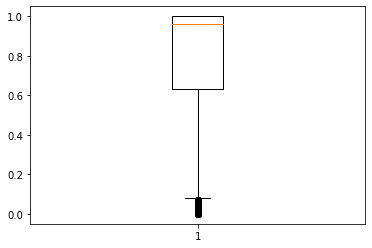

In [34]:
plt.boxplot(list(ts2label.values()))
plt.show()

In [33]:
y = list(ts2label.values())
for thres in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]:
    p = [_ for _ in y if _ >=thres]
    n = [_ for _ in y if _ < thres]
    print('thres : {}, P : {:,}, N : {:,}\n'.format(thres, len(p), len(n)))

thres : 0.1, P : 266,268, N : 19,999

thres : 0.2, P : 261,612, N : 24,655

thres : 0.3, P : 255,995, N : 30,272

thres : 0.4, P : 249,274, N : 36,993

thres : 0.5, P : 240,368, N : 45,899

thres : 0.6, P : 219,440, N : 66,827

thres : 0.7, P : 204,415, N : 81,852

thres : 0.8, P : 188,397, N : 97,870

thres : 0.85, P : 178,068, N : 108,199

thres : 0.9, P : 165,770, N : 120,497

thres : 0.95, P : 148,585, N : 137,682



In [8]:
def label_y(y_arr, THRES):
    return [1 if _ >= THRES else 0 for _ in y_arr]

In [9]:
def onehot_enc(aa):
    return [1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ']

In [10]:
THRES = 0.8
df_digest = pd.DataFrame({'tryptic_site':list(ts2label.keys()), 'label':label_y(list(ts2label.values()), THRES)})

In [11]:
X = np.array([[__ for _ in ts for __ in onehot_enc(_)] for ts in df_digest.tryptic_site.values])
y = df_digest.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, random_state=77)
print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)
RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_digest.fit(X_train, y_train)

(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)


RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [12]:
y_pred = RF_digest.predict(X_test)
print(classification_report(y_test, y_pred))
probs = RF_digest.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, probs)
print('AUC : {}'.format(rf_auc))

              precision    recall  f1-score   support

           0       0.78      0.50      0.61     24336
           1       0.78      0.93      0.85     47231

    accuracy                           0.78     71567
   macro avg       0.78      0.71      0.73     71567
weighted avg       0.78      0.78      0.77     71567

AUC : 0.8342098763688214


In [13]:
RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_digest.fit(X, y)  # for adjusting Detectability

RandomForestClassifier(max_features='sqrt', n_estimators=200)

# Detectability

In [14]:
def cal_digestibility(seq_li, model):
    noseq_idx = [idx for idx, _ in enumerate(seq_li) if _ == '-']
    X = np.array([[__ for _ in seq for __ in onehot_enc(_)] if seq != '-' else [0]*315 for seq in seq_li])
    y_pred = model.predict_proba(X)[:, 1]  # positive probability = digestibility
    y_pred[noseq_idx] = 1
    return y_pred

In [15]:
def labelling_detect(df, aa2val, RF_digest):
    # set tryptic site 9mer
    df['miss'] = [sum([1 for _ in p[:-1] if _ in 'KR']) for p in df.PEP.values]
#     df['En'] = df.En.apply(lambda x: x[3:-3]).values
#     df['Ec'] = df.Ec.apply(lambda x: x[3:-3]).values
#     df['E1'] = df.E1.apply(lambda x: x[3:-3] if x != '-' else '-').values
#     df['E2'] = df.E2.apply(lambda x: x[3:-3] if x != '-' else '-').values

    # digestibility
    score_n = cal_digestibility(df.En.values, RF_digest)
    score_c = cal_digestibility(df.Ec.values, RF_digest)
    score_m1 = cal_digestibility(df.E1.values, RF_digest)
    score_m2 = cal_digestibility(df.E2.values, RF_digest)
    df['digestibility'] = score_n * score_c * score_m1 * score_m2
    
    # get AA index
    cols = list(range(21+len(aa2val['A'])))  # aa_cnt + aa_index length sum 
    cols_value = []
    for seq in df.PEP.values:
        aa_cnt = [seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYVZ']
        aa_index = list(np.array([aa2val[aa] for aa in seq]).sum(axis=0))
        cols_value.append(aa_cnt+aa_index)
    df[cols] = cols_value

    df.drop(['peptide', 'En', 'Ec', 'E1', 'E2', 'protein', 'PEP'], axis=1, inplace=True)
    return df

In [16]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
df_detect_peptide_test = pd.read_csv('data/df_detect_peptide_test.csv')

# # AA index  # for mRMR
# df_aaindex = pd.read_csv('data/aaindex/df_aaindex.csv')
# tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
# aa2val = dict()
# for aa, val in zip(tmp.index, tmp.values):
#     aa2val[aa]=val
    
# AA index
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8826723700804007


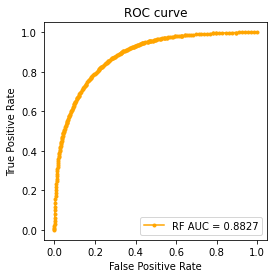

In [52]:
train_idx = df_detect_peptide_train.shape[0]
df = pd.concat([df_detect_peptide_train, df_detect_peptide_test], axis=0)
df = labelling_detect(df, aa2val, RF_digest)
train = df.iloc[:train_idx]
test = df.iloc[train_idx:]

X_train = train.drop('ID', axis=1).values
y_train = train.ID.values
X_test = test.drop('ID', axis=1).values
y_test = test.ID.values
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

RF_detect = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_detect.fit(X_train, y_train)

# prediction
y_pred = RF_detect.predict(X_test)
print(classification_report(y_test, y_pred))

# AUC
probs = RF_detect.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Loop compare

*********************THRESHOLD 0.1*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.81      0.23      0.36      4894
           1       0.95      1.00      0.97     66673

    accuracy                           0.94     71567
   macro avg       0.88      0.61      0.67     71567
weighted avg       0.94      0.94      0.93     71567

AUC : 0.9074231720973839
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8821683082424043


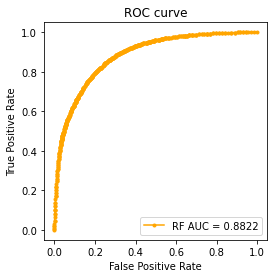

*********************THRESHOLD 0.2*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.79      0.30      0.43      6032
           1       0.94      0.99      0.97     65535

    accuracy                           0.93     71567
   macro avg       0.86      0.64      0.70     71567
weighted avg       0.93      0.93      0.92     71567

AUC : 0.9073133580290687
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8817124304679496


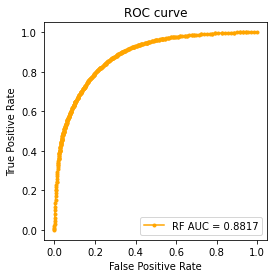

*********************THRESHOLD 0.3*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.78      0.33      0.47      7423
           1       0.93      0.99      0.96     64144

    accuracy                           0.92     71567
   macro avg       0.86      0.66      0.71     71567
weighted avg       0.91      0.92      0.91     71567

AUC : 0.905443085512467
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8818924283912384


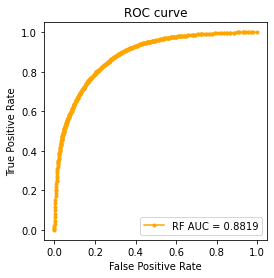

*********************THRESHOLD 0.4*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.79      0.34      0.48      9095
           1       0.91      0.99      0.95     62472

    accuracy                           0.90     71567
   macro avg       0.85      0.67      0.71     71567
weighted avg       0.90      0.90      0.89     71567

AUC : 0.8969161617059748
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8818223666882228


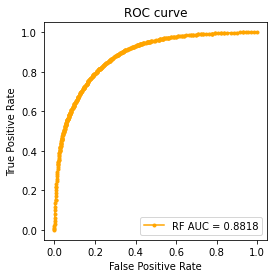

*********************THRESHOLD 0.5*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.79      0.36      0.50     11287
           1       0.89      0.98      0.93     60280

    accuracy                           0.88     71567
   macro avg       0.84      0.67      0.72     71567
weighted avg       0.87      0.88      0.87     71567

AUC : 0.8846588737511472
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.79     67298
   macro avg       0.79      0.79      0.79     67298
weighted avg       0.79      0.79      0.79     67298

rf auc : 0.8817461870889316


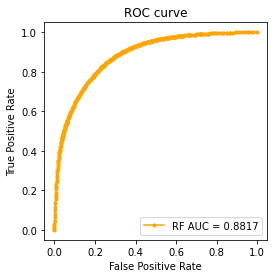

*********************THRESHOLD 0.6*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.81      0.39      0.52     16513
           1       0.84      0.97      0.90     55054

    accuracy                           0.84     71567
   macro avg       0.82      0.68      0.71     71567
weighted avg       0.83      0.84      0.81     71567

AUC : 0.8576364235185234
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.79     67298
   macro avg       0.79      0.79      0.79     67298
weighted avg       0.79      0.79      0.79     67298

rf auc : 0.8817679106107646


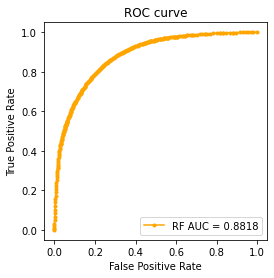

*********************THRESHOLD 0.7*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.79      0.44      0.56     20278
           1       0.81      0.96      0.88     51289

    accuracy                           0.81     71567
   macro avg       0.80      0.70      0.72     71567
weighted avg       0.81      0.81      0.79     71567

AUC : 0.8460467244004741
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8824294117887288


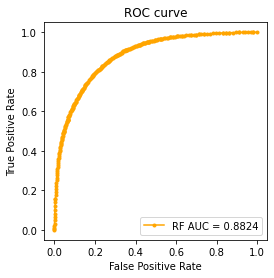

*********************THRESHOLD 0.8*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.78      0.50      0.61     24336
           1       0.78      0.93      0.85     47231

    accuracy                           0.78     71567
   macro avg       0.78      0.71      0.73     71567
weighted avg       0.78      0.78      0.77     71567

AUC : 0.8348553968234877
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8824873167452043


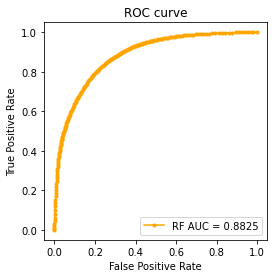

*********************THRESHOLD 0.85*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.77      0.55      0.64     26995
           1       0.77      0.90      0.83     44572

    accuracy                           0.77     71567
   macro avg       0.77      0.72      0.73     71567
weighted avg       0.77      0.77      0.76     71567

AUC : 0.8276823984325941
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8827006539795306


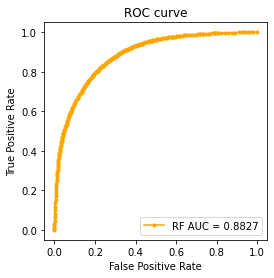

*********************THRESHOLD 0.9*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.76      0.61      0.68     30085
           1       0.75      0.86      0.80     41482

    accuracy                           0.75     71567
   macro avg       0.75      0.73      0.74     71567
weighted avg       0.75      0.75      0.75     71567

AUC : 0.8200166416934959
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8829130033595208


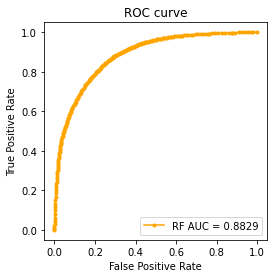

*********************THRESHOLD 0.95*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     34364
           1       0.73      0.78      0.75     37203

    accuracy                           0.73     71567
   macro avg       0.74      0.73      0.73     71567
weighted avg       0.74      0.73      0.73     71567

AUC : 0.8067329696311774
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8825127284920768


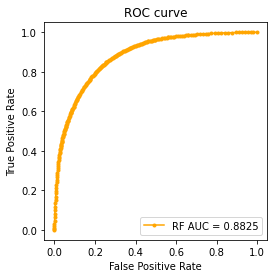

In [53]:
for THRES in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]:
    print('*********************THRESHOLD {}*******************'.format(THRES))
    df_digest = pd.DataFrame({'tryptic_site':list(ts2label.keys()), 'label':label_y(list(ts2label.values()), THRES)})
    X = np.array([[__ for _ in ts for __ in onehot_enc(_)] for ts in df_digest.tryptic_site.values])
    y = df_digest.label.values
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25, random_state=77)
    print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
    RF_digest.fit(X_train, y_train)
    y_pred = RF_digest.predict(X_test)
    print(classification_report(y_test, y_pred))
    probs = RF_digest.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, probs)
    print('AUC : {}'.format(rf_auc))
    RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
    RF_digest.fit(X, y)  # for adjusting Detectability

    train_idx = df_detect_peptide_train.shape[0]
    df = pd.concat([df_detect_peptide_train, df_detect_peptide_test], axis=0)
    df = labelling_detect(df, aa2val, RF_digest)
    train = df.iloc[:train_idx]
    test = df.iloc[train_idx:]

    X_train = train.drop('ID', axis=1).values
    y_train = train.ID.values
    X_test = test.drop('ID', axis=1).values
    y_test = test.ID.values
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    RF_detect = RandomForestClassifier(n_estimators=200, max_features='sqrt')
    RF_detect.fit(X_train, y_train)

    # prediction
    y_pred = RF_detect.predict(X_test)
    print(classification_report(y_test, y_pred))

    # AUC
    probs = RF_detect.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, probs)
    print('rf auc : {}'.format(rf_auc))
    # plot the roc curve for the model
    rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(4, 4))
    plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
    plt.title('ROC curve')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

# use LSTM

In [17]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [18]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [19]:
def labelling_detect_forDL(df, aa2val, RF_digest):
    # set tryptic site 9mer
    df['miss'] = [sum([1 for _ in p[:-1] if _ in 'KR']) for p in df.PEP.values]
#     df['En'] = df.En.apply(lambda x: x[3:-3]).values
#     df['Ec'] = df.Ec.apply(lambda x: x[3:-3]).values
#     df['E1'] = df.E1.apply(lambda x: x[3:-3] if x != '-' else '-').values
#     df['E2'] = df.E2.apply(lambda x: x[3:-3] if x != '-' else '-').values

    # digestibility
    score_n = cal_digestibility(df.En.values, RF_digest)
    score_c = cal_digestibility(df.Ec.values, RF_digest)
    score_m1 = cal_digestibility(df.E1.values, RF_digest)
    score_m2 = cal_digestibility(df.E2.values, RF_digest)
    df['digestibility'] = score_n * score_c * score_m1 * score_m2
    df['score_n'] = score_n
    df['score_c'] = score_c
    df['score_m1'] = score_m1
    df['score_m2'] = score_m2
    return df

In [20]:
train_idx = df_detect_peptide_train.shape[0]
df = pd.concat([df_detect_peptide_train, df_detect_peptide_test], axis=0)
df = labelling_detect_forDL(df, aa2val, RF_digest)
df = df[['peptide', 'ID', 'score_n', 'score_c', 'score_m1', 'score_m2', 'digestibility']]

In [21]:
train = df.iloc[:train_idx]
train, val = train_test_split(train, test_size=0.2, random_state=7)
test = df.iloc[train_idx:]

* Label Encoding

In [22]:
def get_data_labelEnc(df):
    pep_data = []
    labelEnc = {k:v for k, v in zip('ARNDCQEGHILKMFPSTWYV', list(range(1, 21)))}
    labelEnc['Z']=0
    for seq, n, c, m1, m2 in df[['peptide', 'score_n', 'score_c', 'score_m1', 'score_m2']].values:
        seq = ''.join(seq.split('.')[:2])  # peptide including N term site
        ts_cnt = sum([1 for _ in seq if _ in 'KR'])
        ts_cnt2misstype = {2:{1:n, 2:c},
                          3:{1:n, 2:m1, 3:c},
                          4:{1:n, 2:m1, 3:m2, 4:c}}
        ts2score = ts_cnt2misstype[ts_cnt]
        ts_idx = 0
        
        pep2label = []
        for aa in seq:
            if aa in 'KR':
                ts_idx += 1
                pep2label.append([labelEnc[aa], ts2score[ts_idx]])
            else:
                pep2label.append([labelEnc[aa], 0])
        pep2label += [[0, 0]] * (31 - len(seq))  # including N terminal of peptide
        
        pep_data.append(pep2label)
        
    return np.array(pep_data), np.array(df.ID.values)

In [23]:
X_train, y_train = get_data_labelEnc(train)
X_val, y_val = get_data_labelEnc(val)
X_test, y_test = get_data_labelEnc(test)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(215352, 31, 2) (53838, 31, 2) (67298, 31, 2) (215352,) (53838,) (67298,)


In [24]:
input1 = tf.keras.layers.Input(shape=((31,2,)))  # peptide with zero padding

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(input1)
net_lstm = tf.keras.layers.Dense(64, activation='relu')(lstm1)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_lstm)

model = tf.keras.Model(inputs=[input1],
                            outputs=[output])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 2)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                8960      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,185
Trainable params: 13,185
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train, y_train,
                    epochs=250,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

Epoch 1/250
1683/1683 [==============================] - 19s 7ms/step - loss: 0.6663 - accuracy: 0.5894 - val_loss: 0.5227 - val_accuracy: 0.7545
Epoch 2/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.5038 - accuracy: 0.7638 - val_loss: 0.4743 - val_accuracy: 0.7790
Epoch 3/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4691 - accuracy: 0.7827 - val_loss: 0.4631 - val_accuracy: 0.7833
Epoch 4/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4578 - accuracy: 0.7895 - val_loss: 0.4489 - val_accuracy: 0.7941
Epoch 5/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4509 - accuracy: 0.7929 - val_loss: 0.4434 - val_accuracy: 0.7961
Epoch 6/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4436 - accuracy: 0.7965 - val_loss: 0.4394 - val_accuracy: 0.7991
Epoch 7/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4389 - accuracy: 0.7995 - val_loss: 0.4346 -

Epoch 57/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4174 - accuracy: 0.8122 - val_loss: 0.4138 - val_accuracy: 0.8125
Epoch 58/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4153 - accuracy: 0.8117 - val_loss: 0.4133 - val_accuracy: 0.8129
Epoch 59/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4160 - accuracy: 0.8123 - val_loss: 0.4137 - val_accuracy: 0.8131
Epoch 60/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4139 - accuracy: 0.8126 - val_loss: 0.4129 - val_accuracy: 0.8133
Epoch 61/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4141 - accuracy: 0.8132 - val_loss: 0.4130 - val_accuracy: 0.8132
Epoch 62/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4148 - accuracy: 0.8121 - val_loss: 0.4134 - val_accuracy: 0.8137
Epoch 63/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4127 - accuracy: 0.8142 - val_loss: 0

1683/1683 [==============================] - 11s 7ms/step - loss: 0.4053 - accuracy: 0.8173 - val_loss: 0.4066 - val_accuracy: 0.8168
Epoch 168/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4060 - accuracy: 0.8169 - val_loss: 0.4054 - val_accuracy: 0.8184
Epoch 169/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4055 - accuracy: 0.8168 - val_loss: 0.4053 - val_accuracy: 0.8185
Epoch 170/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4053 - accuracy: 0.8174 - val_loss: 0.4067 - val_accuracy: 0.8181
Epoch 171/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4040 - accuracy: 0.8184 - val_loss: 0.4065 - val_accuracy: 0.8185
Epoch 172/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4051 - accuracy: 0.8181 - val_loss: 0.4074 - val_accuracy: 0.8176
Epoch 173/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4056 - accuracy: 0.8167 - val_loss: 0.4091 -

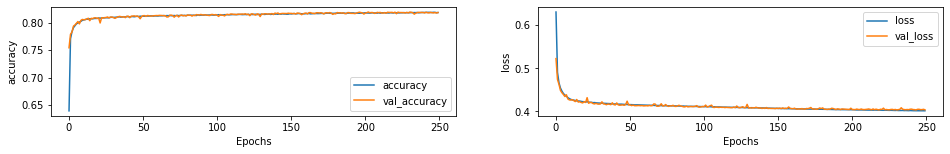

In [26]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

2104/2104 [==============================] - 6s 3ms/step - loss: 0.4052 - accuracy: 0.8158
Test Loss: 0.4052272140979767
Test Accuracy: 0.8158192038536072
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     33706
           1       0.82      0.82      0.82     33592

    accuracy                           0.82     67298
   macro avg       0.82      0.82      0.82     67298
weighted avg       0.82      0.82      0.82     67298

rf auc : 0.895555653235032


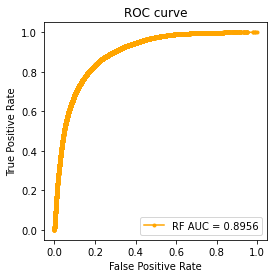

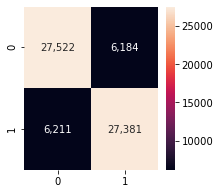

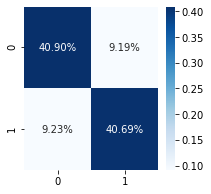

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# without digestibility
  - labelencoding

In [28]:
def get_data_labelEnc_without_digestibility(df):
    pep_data = []
    labelEnc = {k:v for k, v in zip('ARNDCQEGHILKMFPSTWYV', list(range(1, 21)))}
    labelEnc['Z']=0
    for seq, n, c, m1, m2 in df[['peptide', 'score_n', 'score_c', 'score_m1', 'score_m2']].values:
        seq = ''.join(seq.split('.')[:2])  # peptide including N term site
        
        pep2label = []
        for aa in seq:
            pep2label.append([labelEnc[aa]])
        pep2label += [[0]] * (31 - len(seq))  # including N terminal of peptide
        
        pep_data.append(pep2label)
        
    return np.array(pep_data), np.array(df.ID.values)

In [40]:
X_train, y_train = get_data_labelEnc_without_digestibility(train)
X_val, y_val = get_data_labelEnc_without_digestibility(val)
X_test, y_test = get_data_labelEnc_without_digestibility(test)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(215352, 31, 1) (53838, 31, 1) (67298, 31, 1) (215352,) (53838,) (67298,)


In [34]:
input1 = tf.keras.layers.Input(shape=((31,1)))  # peptide with zero padding

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(input1)
net_lstm = tf.keras.layers.Dense(64, activation='relu')(lstm1)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_lstm)

model_LabelEnc_without = tf.keras.Model(inputs=[input1],
                            outputs=[output])
model_LabelEnc_without.summary()

model_LabelEnc_without.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 31, 1)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                8704      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [35]:
history_model_LabelEnc_without = model_LabelEnc_without.fit(X_train, y_train,
                    epochs=250,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

Epoch 1/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.6748 - accuracy: 0.5764 - val_loss: 0.6603 - val_accuracy: 0.6067
Epoch 2/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.6594 - accuracy: 0.6079 - val_loss: 0.6582 - val_accuracy: 0.6082
Epoch 3/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.6583 - accuracy: 0.6080 - val_loss: 0.6567 - val_accuracy: 0.6107
Epoch 4/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.6568 - accuracy: 0.6098 - val_loss: 0.6562 - val_accuracy: 0.6104
Epoch 5/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.6551 - accuracy: 0.6117 - val_loss: 0.6561 - val_accuracy: 0.6111
Epoch 6/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.6536 - accuracy: 0.6141 - val_loss: 0.6532 - val_accuracy: 0.6155
Epoch 7/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.6534 - accuracy: 0.6146 - val_loss: 0.6523 - val_a

1683/1683 [==============================] - 9s 5ms/step - loss: 0.5765 - accuracy: 0.6984 - val_loss: 0.5780 - val_accuracy: 0.6958
Epoch 114/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5755 - accuracy: 0.6993 - val_loss: 0.5758 - val_accuracy: 0.6987
Epoch 115/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5762 - accuracy: 0.6976 - val_loss: 0.5768 - val_accuracy: 0.6968
Epoch 116/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5765 - accuracy: 0.6984 - val_loss: 0.5796 - val_accuracy: 0.6970
Epoch 117/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5757 - accuracy: 0.6995 - val_loss: 0.5771 - val_accuracy: 0.6979
Epoch 118/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5741 - accuracy: 0.7004 - val_loss: 0.5759 - val_accuracy: 0.6983
Epoch 119/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5743 - accuracy: 0.6995 - val_loss: 0.5759 - val_ac

Epoch 169/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5608 - accuracy: 0.7100 - val_loss: 0.5659 - val_accuracy: 0.7054
Epoch 170/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5627 - accuracy: 0.7088 - val_loss: 0.5654 - val_accuracy: 0.7068
Epoch 171/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5588 - accuracy: 0.7118 - val_loss: 0.5649 - val_accuracy: 0.7063
Epoch 172/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5606 - accuracy: 0.7102 - val_loss: 0.5617 - val_accuracy: 0.7091
Epoch 173/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5614 - accuracy: 0.7093 - val_loss: 0.5628 - val_accuracy: 0.7079
Epoch 174/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5587 - accuracy: 0.7103 - val_loss: 0.5616 - val_accuracy: 0.7090
Epoch 175/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5608 - accuracy: 0.7096 - val_loss: 0

Epoch 225/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5464 - accuracy: 0.7208 - val_loss: 0.5510 - val_accuracy: 0.7197
Epoch 226/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5499 - accuracy: 0.7194 - val_loss: 0.5508 - val_accuracy: 0.7182
Epoch 227/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5484 - accuracy: 0.7200 - val_loss: 0.5515 - val_accuracy: 0.7181
Epoch 228/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5496 - accuracy: 0.7182 - val_loss: 0.5518 - val_accuracy: 0.7184
Epoch 229/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5482 - accuracy: 0.7205 - val_loss: 0.5542 - val_accuracy: 0.7168
Epoch 230/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5465 - accuracy: 0.7223 - val_loss: 0.5504 - val_accuracy: 0.7186
Epoch 231/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.5459 - accuracy: 0.7224 - val_loss: 0

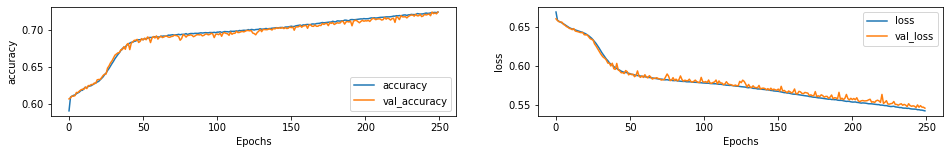

In [36]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history_model_LabelEnc_without, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history_model_LabelEnc_without, 'loss')

2104/2104 [==============================] - 5s 2ms/step - loss: 0.5457 - accuracy: 0.7239
Test Loss: 0.5456642508506775
Test Accuracy: 0.7239294052124023
              precision    recall  f1-score   support

           0       0.74      0.68      0.71     33706
           1       0.71      0.76      0.73     33592

    accuracy                           0.72     67298
   macro avg       0.73      0.72      0.72     67298
weighted avg       0.73      0.72      0.72     67298

rf auc : 0.7958959102770441


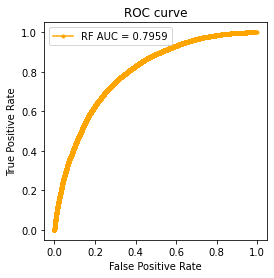

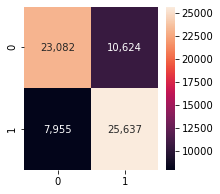

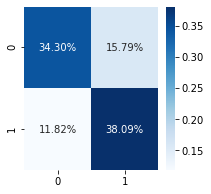

In [37]:
test_loss, test_acc = model_LabelEnc_without.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_LabelEnc_without.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_LabelEnc_without.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_LabelEnc_without
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

* Embedding

In [48]:
def get_data_labelEnc2_without_digestibility(df):
    pep_data = []
    labelEnc = {k:v for k, v in zip('ARNDCQEGHILKMFPSTWYV', list(range(1, 21)))}
    labelEnc['Z']=0
    for seq, n, c, m1, m2 in df[['peptide', 'score_n', 'score_c', 'score_m1', 'score_m2']].values:
        seq = ''.join(seq.split('.')[:2])  # peptide including N term site
        
        pep2label = []
        for aa in seq:
            pep2label.append(labelEnc[aa])
        pep2label += [0] * (31 - len(seq))  # including N terminal of peptide
        
        pep_data.append(pep2label)
        
    return np.array(pep_data), np.array(df.ID.values)

In [49]:
X_train, y_train = get_data_labelEnc2_without_digestibility(train)
X_val, y_val = get_data_labelEnc2_without_digestibility(val)
X_test, y_test = get_data_labelEnc2_without_digestibility(test)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(215352, 31) (53838, 31) (67298, 31) (215352,) (53838,) (67298,)


In [50]:
input1 = tf.keras.layers.Input(shape=(31,))  # peptide with zero padding
embed = tf.keras.layers.Embedding(21, 64, input_length=31, mask_zero=True)(input1)

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embed)
net_lstm = tf.keras.layers.Dense(64, activation='relu')(lstm1)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_lstm)

model_embed_without = tf.keras.Model(inputs=[input1],
                            outputs=[output])
model_embed_without.summary()

model_embed_without.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 31)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 31, 64)            1344      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [51]:
history_model_embed_without = model_embed_without.fit(X_train, y_train,
                    epochs=250,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

Epoch 1/250
1683/1683 [==============================] - 23s 10ms/step - loss: 0.5845 - accuracy: 0.6935 - val_loss: 0.4736 - val_accuracy: 0.7719
Epoch 2/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.4687 - accuracy: 0.7756 - val_loss: 0.4599 - val_accuracy: 0.7801
Epoch 3/250
1683/1683 [==============================] - 16s 9ms/step - loss: 0.4597 - accuracy: 0.7795 - val_loss: 0.4478 - val_accuracy: 0.7876
Epoch 4/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.4467 - accuracy: 0.7879 - val_loss: 0.4382 - val_accuracy: 0.7938
Epoch 5/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.4358 - accuracy: 0.7956 - val_loss: 0.4306 - val_accuracy: 0.7988
Epoch 6/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.4282 - accuracy: 0.8001 - val_loss: 0.4241 - val_accuracy: 0.8032
Epoch 7/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.4215 - accuracy: 0.8037 - val_loss: 0.4232 

Epoch 57/250
1683/1683 [==============================] - 16s 9ms/step - loss: 0.3775 - accuracy: 0.8318 - val_loss: 0.3858 - val_accuracy: 0.8282
Epoch 58/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.3787 - accuracy: 0.8299 - val_loss: 0.3839 - val_accuracy: 0.8296
Epoch 59/250
1683/1683 [==============================] - 16s 9ms/step - loss: 0.3784 - accuracy: 0.8312 - val_loss: 0.3829 - val_accuracy: 0.8299
Epoch 60/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.3783 - accuracy: 0.8304 - val_loss: 0.3846 - val_accuracy: 0.8292
Epoch 61/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.3785 - accuracy: 0.8307 - val_loss: 0.3829 - val_accuracy: 0.8294
Epoch 62/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.3770 - accuracy: 0.8320 - val_loss: 0.3833 - val_accuracy: 0.8299
Epoch 63/250
1683/1683 [==============================] - 15s 9ms/step - loss: 0.3800 - accuracy: 0.8303 - val_loss: 0

1683/1683 [==============================] - 16s 9ms/step - loss: 0.3586 - accuracy: 0.8414 - val_loss: 0.3739 - val_accuracy: 0.8363
Epoch 168/250
1683/1683 [==============================] - 17s 10ms/step - loss: 0.3561 - accuracy: 0.8423 - val_loss: 0.3722 - val_accuracy: 0.8369
Epoch 169/250
1683/1683 [==============================] - 18s 10ms/step - loss: 0.3566 - accuracy: 0.8420 - val_loss: 0.3728 - val_accuracy: 0.8360
Epoch 170/250
1683/1683 [==============================] - 18s 10ms/step - loss: 0.3591 - accuracy: 0.8412 - val_loss: 0.3739 - val_accuracy: 0.8360
Epoch 171/250
1683/1683 [==============================] - 17s 10ms/step - loss: 0.3565 - accuracy: 0.8419 - val_loss: 0.3731 - val_accuracy: 0.8367
Epoch 172/250
1683/1683 [==============================] - 17s 10ms/step - loss: 0.3579 - accuracy: 0.8432 - val_loss: 0.3743 - val_accuracy: 0.8371
Epoch 173/250
1683/1683 [==============================] - 17s 10ms/step - loss: 0.3555 - accuracy: 0.8431 - val_loss: 0.

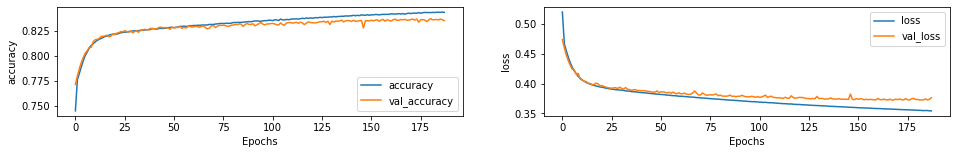

In [52]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history_model_embed_without, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history_model_embed_without, 'loss')

2104/2104 [==============================] - 8s 4ms/step - loss: 0.3749 - accuracy: 0.8330
Test Loss: 0.37488773465156555
Test Accuracy: 0.8329519629478455
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     33706
           1       0.84      0.82      0.83     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298

rf auc : 0.9133670387348556


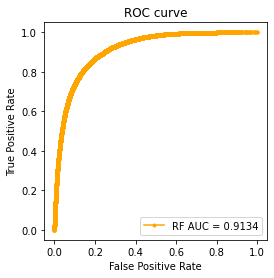

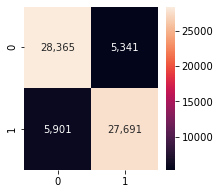

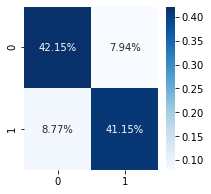

In [53]:
test_loss, test_acc = model_embed_without.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_embed_without.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_embed_without.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_embed_without
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

* onehot encoding

In [54]:
def get_data_onehotEnc_without_digestibility(df):
    pep_data = []
    for seq, n, c, m1, m2 in df[['peptide', 'score_n', 'score_c', 'score_m1', 'score_m2']].values:
        seq = ''.join(seq.split('.')[:2])  # peptide including N term site
        
        pep2onehot = []
        for aa in seq:
            if aa in 'ARNDCQEGHILKMFPSTWYV':
                pep2onehot.append([1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYV'])
            else:
                pep2onehot.append([0] * 20)
        pep2onehot += [[0]*20] * (31 - len(seq))  # including N terminal of peptide
        
        pep_data.append(pep2onehot)
        
    return np.array(pep_data), np.array(df.ID.values)

In [55]:
X_train, y_train = get_data_onehotEnc_without_digestibility(train)
X_val, y_val = get_data_onehotEnc_without_digestibility(val)
X_test, y_test = get_data_onehotEnc_without_digestibility(test)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(215352, 31, 20) (53838, 31, 20) (67298, 31, 20) (215352,) (53838,) (67298,)


In [56]:
input1 = tf.keras.layers.Input(shape=((31,20)))  # peptide with zero padding

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(input1)
net_lstm = tf.keras.layers.Dense(64, activation='relu')(lstm1)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_lstm)

model_OnehotEnc_without = tf.keras.Model(inputs=[input1],
                            outputs=[output])
model_OnehotEnc_without.summary()

model_OnehotEnc_without.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 31, 20)]          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                13568     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 17,793
Trainable params: 17,793
Non-trainable params: 0
_________________________________________________________________


In [57]:
history_model_OnehotEnc_without = model_OnehotEnc_without.fit(X_train, y_train,
                    epochs=250,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

Epoch 1/250
1683/1683 [==============================] - 12s 6ms/step - loss: 0.5976 - accuracy: 0.6773 - val_loss: 0.4770 - val_accuracy: 0.7727
Epoch 2/250
1683/1683 [==============================] - 9s 6ms/step - loss: 0.4736 - accuracy: 0.7731 - val_loss: 0.4565 - val_accuracy: 0.7826
Epoch 3/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.4529 - accuracy: 0.7849 - val_loss: 0.4481 - val_accuracy: 0.7875
Epoch 4/250
1683/1683 [==============================] - 9s 6ms/step - loss: 0.4445 - accuracy: 0.7899 - val_loss: 0.4367 - val_accuracy: 0.7947
Epoch 5/250
1683/1683 [==============================] - 10s 6ms/step - loss: 0.4364 - accuracy: 0.7942 - val_loss: 0.4368 - val_accuracy: 0.7954
Epoch 6/250
1683/1683 [==============================] - 10s 6ms/step - loss: 0.4311 - accuracy: 0.7986 - val_loss: 0.4299 - val_accuracy: 0.7994
Epoch 7/250
1683/1683 [==============================] - 9s 6ms/step - loss: 0.4277 - accuracy: 0.8006 - val_loss: 0.4271 - val

1683/1683 [==============================] - 9s 5ms/step - loss: 0.3766 - accuracy: 0.8334 - val_loss: 0.3812 - val_accuracy: 0.8320
Epoch 114/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3735 - accuracy: 0.8336 - val_loss: 0.3856 - val_accuracy: 0.8286
Epoch 115/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3759 - accuracy: 0.8325 - val_loss: 0.3824 - val_accuracy: 0.8298
Epoch 116/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3736 - accuracy: 0.8338 - val_loss: 0.3804 - val_accuracy: 0.8316
Epoch 117/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3753 - accuracy: 0.8333 - val_loss: 0.3805 - val_accuracy: 0.8300
Epoch 118/250
1683/1683 [==============================] - 10s 6ms/step - loss: 0.3734 - accuracy: 0.8332 - val_loss: 0.3806 - val_accuracy: 0.8316
Epoch 119/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3756 - accuracy: 0.8325 - val_loss: 0.3807 - val_a

Epoch 169/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3667 - accuracy: 0.8384 - val_loss: 0.3777 - val_accuracy: 0.8327
Epoch 170/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3688 - accuracy: 0.8361 - val_loss: 0.3777 - val_accuracy: 0.8332
Epoch 171/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3678 - accuracy: 0.8367 - val_loss: 0.3778 - val_accuracy: 0.8321
Epoch 172/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3669 - accuracy: 0.8375 - val_loss: 0.3776 - val_accuracy: 0.8332
Epoch 173/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3670 - accuracy: 0.8383 - val_loss: 0.3771 - val_accuracy: 0.8331
Epoch 174/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3671 - accuracy: 0.8382 - val_loss: 0.3776 - val_accuracy: 0.8331
Epoch 175/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3655 - accuracy: 0.8384 - val_loss: 0

Epoch 225/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3604 - accuracy: 0.8401 - val_loss: 0.3754 - val_accuracy: 0.8334
Epoch 226/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3601 - accuracy: 0.8417 - val_loss: 0.3756 - val_accuracy: 0.8344
Epoch 227/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3588 - accuracy: 0.8415 - val_loss: 0.3761 - val_accuracy: 0.8329
Epoch 228/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3611 - accuracy: 0.8400 - val_loss: 0.3772 - val_accuracy: 0.8334
Epoch 229/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3595 - accuracy: 0.8411 - val_loss: 0.3753 - val_accuracy: 0.8329
Epoch 230/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3602 - accuracy: 0.8412 - val_loss: 0.3752 - val_accuracy: 0.8339
Epoch 231/250
1683/1683 [==============================] - 9s 5ms/step - loss: 0.3618 - accuracy: 0.8408 - val_loss: 0

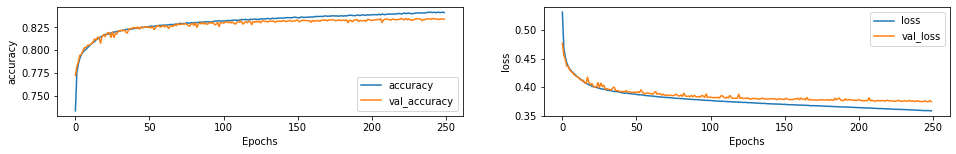

In [58]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history_model_OnehotEnc_without, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history_model_OnehotEnc_without, 'loss')

2104/2104 [==============================] - 5s 2ms/step - loss: 0.3712 - accuracy: 0.8337
Test Loss: 0.37123605608940125
Test Accuracy: 0.8336800336837769
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     33706
           1       0.82      0.86      0.84     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298

rf auc : 0.9134110289438476


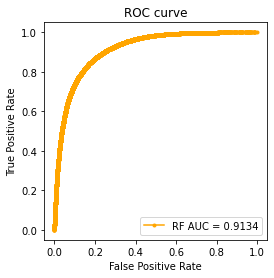

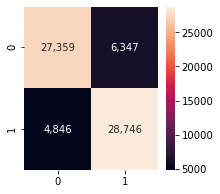

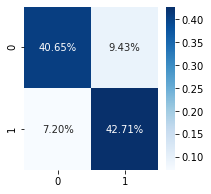

In [59]:
test_loss, test_acc = model_OnehotEnc_without.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_OnehotEnc_without.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_OnehotEnc_without.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_OnehotEnc_without
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# with AP3 digestibility

In [ ]:
import joblib
RF_digest_ap3 = joblib.load('compareModel/2019ACS_AP3/digestibility.joblib')

In [20]:
train_idx = df_detect_peptide_train.shape[0]
df = pd.concat([df_detect_peptide_train, df_detect_peptide_test], axis=0)
df = labelling_detect_forDL(df, aa2val, RF_digest_ap3)
df = df[['peptide', 'ID', 'score_n', 'score_c', 'score_m1', 'score_m2', 'digestibility']]
train = df.iloc[:train_idx]
train, val = train_test_split(train, test_size=0.2, random_state=7)
test = df.iloc[train_idx:]

X_train, y_train = get_data_labelEnc(train)
X_val, y_val = get_data_labelEnc(val)
X_test, y_test = get_data_labelEnc(test)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

In [24]:
input1 = tf.keras.layers.Input(shape=((31,2,)))  # peptide with zero padding

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(input1)
net_lstm = tf.keras.layers.Dense(64, activation='relu')(lstm1)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_lstm)

model_ap3 = tf.keras.Model(inputs=[input1],
                            outputs=[output])
model_ap3.summary()

model_ap3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 2)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                8960      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,185
Trainable params: 13,185
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_ap3 = model_ap3.fit(X_train, y_train,
                    epochs=250,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

Epoch 1/250
1683/1683 [==============================] - 19s 7ms/step - loss: 0.6663 - accuracy: 0.5894 - val_loss: 0.5227 - val_accuracy: 0.7545
Epoch 2/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.5038 - accuracy: 0.7638 - val_loss: 0.4743 - val_accuracy: 0.7790
Epoch 3/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4691 - accuracy: 0.7827 - val_loss: 0.4631 - val_accuracy: 0.7833
Epoch 4/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4578 - accuracy: 0.7895 - val_loss: 0.4489 - val_accuracy: 0.7941
Epoch 5/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4509 - accuracy: 0.7929 - val_loss: 0.4434 - val_accuracy: 0.7961
Epoch 6/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4436 - accuracy: 0.7965 - val_loss: 0.4394 - val_accuracy: 0.7991
Epoch 7/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4389 - accuracy: 0.7995 - val_loss: 0.4346 -

Epoch 57/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4174 - accuracy: 0.8122 - val_loss: 0.4138 - val_accuracy: 0.8125
Epoch 58/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4153 - accuracy: 0.8117 - val_loss: 0.4133 - val_accuracy: 0.8129
Epoch 59/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4160 - accuracy: 0.8123 - val_loss: 0.4137 - val_accuracy: 0.8131
Epoch 60/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4139 - accuracy: 0.8126 - val_loss: 0.4129 - val_accuracy: 0.8133
Epoch 61/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4141 - accuracy: 0.8132 - val_loss: 0.4130 - val_accuracy: 0.8132
Epoch 62/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4148 - accuracy: 0.8121 - val_loss: 0.4134 - val_accuracy: 0.8137
Epoch 63/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4127 - accuracy: 0.8142 - val_loss: 0

1683/1683 [==============================] - 11s 7ms/step - loss: 0.4053 - accuracy: 0.8173 - val_loss: 0.4066 - val_accuracy: 0.8168
Epoch 168/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4060 - accuracy: 0.8169 - val_loss: 0.4054 - val_accuracy: 0.8184
Epoch 169/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4055 - accuracy: 0.8168 - val_loss: 0.4053 - val_accuracy: 0.8185
Epoch 170/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4053 - accuracy: 0.8174 - val_loss: 0.4067 - val_accuracy: 0.8181
Epoch 171/250
1683/1683 [==============================] - 11s 6ms/step - loss: 0.4040 - accuracy: 0.8184 - val_loss: 0.4065 - val_accuracy: 0.8185
Epoch 172/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4051 - accuracy: 0.8181 - val_loss: 0.4074 - val_accuracy: 0.8176
Epoch 173/250
1683/1683 [==============================] - 11s 7ms/step - loss: 0.4056 - accuracy: 0.8167 - val_loss: 0.4091 -

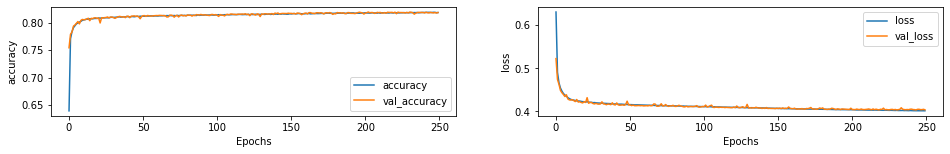

In [26]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history_ap3, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history_ap3, 'loss')

2104/2104 [==============================] - 6s 3ms/step - loss: 0.4052 - accuracy: 0.8158
Test Loss: 0.4052272140979767
Test Accuracy: 0.8158192038536072
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     33706
           1       0.82      0.82      0.82     33592

    accuracy                           0.82     67298
   macro avg       0.82      0.82      0.82     67298
weighted avg       0.82      0.82      0.82     67298

rf auc : 0.895555653235032


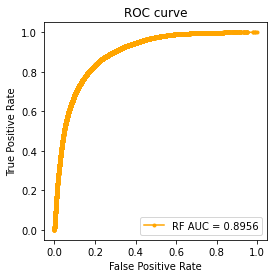

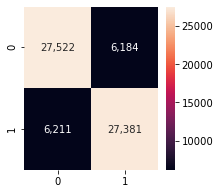

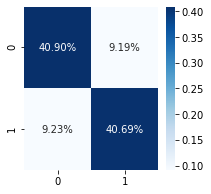

In [27]:
test_loss, test_acc = model_ap3.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_ap3.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_ap3.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_ap3
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()